# STEP B

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def read_image_and_compute_keypoints(object_imgs, scene_imgs, detector):
    imgs_dict = {}

    for name_img in object_imgs:
        img_load = cv2.imread('models/' + name_img + '.jpg', cv2.IMREAD_GRAYSCALE)
        
        """
        # Enlever le centre de l'image
        row = int(img_load.shape[0]/2)
        col = int(img_load.shape[1]/2)
        pour = 0.5
        new_color = 255 # White
        img_load[int(row - row*pour) : int(row + row*pour), int(col - col*pour): int(col + col*pour)] = new_color
        #
        """

        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    for name_img in scene_imgs:
        img_load = cv2.imread('scenes/' + name_img + '.png', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    return imgs_dict

def matching_and_localize_objects_in_scene(imgs_dict, name_scene_img, ratio_test=0.45):
    all_scene_corners = {}
    all_good ={}
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']
        
        #-- matching
        matches = matcher.knnMatch(object_des, scene_des, k=2)
    
        #-- store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)
                
        if len(good) > 30:        
            #-- Get the keypoints from the good matches
            object_good_kp = np.float32([ object_kp[m.queryIdx].pt for m in good ])
            scene_good_kp = np.float32([ scene_kp[m.trainIdx].pt for m in good ])   


            #-- Get the corners of object
            h,w = imgs_dict[name]['shape'][0:2]
            object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            #-- Get the homography of object/scene
            H, _ =  cv2.findHomography(object_good_kp, scene_good_kp, cv2.RANSAC, 5.0)

            #-- Get the corners of object in scene
            scene_corners = cv2.perspectiveTransform(object_corners, H)


            all_scene_corners[name] = scene_corners
            all_good[name] = good
        
    return all_scene_corners, all_good

def check_best_color_matches(all_scene_corners, name_scene_img):
    
    scene_img_bgr = cv2.imread('scenes/' + name_scene_img + '.png')
    best_all_scene_corners = {}
    
    for name in all_scene_corners.keys():

        x_min = max(int(np.min(all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(all_scene_corners[name], axis=0)[0][1])
        
        object_img_bgr = cv2.imread('models/' + name + '.jpg')
        
        object_img_mean_color = object_img_bgr.mean(axis=0).mean(axis=0)
        object_in_scene_img = scene_img_bgr[y_min:y_max,x_min:x_max]
        object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - object_in_scene_img_mean_color)]))
        
        #color_diff = (np.sum([value **2 for value in (object_img_mean_color - object_in_scene_img_mean_color)]))/4
        
        if color_diff < 60:
            best_all_scene_corners[name] = all_scene_corners[name]
        
    return best_all_scene_corners

def drawn_object_lines_in_scene(img_scene, best_all_scene_corners):
    for name in best_all_scene_corners.keys():
        scene_corners = best_all_scene_corners[name]
        img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], 
                                  isClosed=True, color=(0,255,0), thickness=5)
    return img_scene

def print_object_found(best_all_scene_corners):
    for name in best_all_scene_corners.keys():  
        x_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(best_all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(best_all_scene_corners[name], axis=0)[0][1])
        
        print('Product {} - {} instance/s found:'.format(name, 1))
        print('\tInstance {} position: {}, width: {}px, height: {}px'.format(1, (x_min, y_min), (x_max-x_min), (y_max-y_min)))
    
    print('_' * 80 + '\n')

def stepA():
    
    detector = cv2.SIFT_create()
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    #matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    
    imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)
    
    
    for scene_name in scene_imgs:
        
        all_scene_corners, all_good= matching_and_localize_objects_in_scene(imgs_dict, scene_name)
        
        best_all_scene_corners = check_best_color_matches(all_scene_corners , scene_name)
        
        
        img_scene_rgb = cv2.cvtColor(cv2.imread('scenes/' + scene_name + '.png'), cv2.COLOR_BGR2RGB)
        img_scene_rgb = drawn_object_lines_in_scene(img_scene_rgb, best_all_scene_corners)

        
        print('Scene {} :'.format(scene_name))
        plt.imshow(img_scene_rgb)
        plt.show()
        print_object_found(best_all_scene_corners)

In [2]:
#-- bank of image step B
object_imgs = ['0', '1', '11', '19', '24', '25', '26']
#object_imgs = ['0', '11']
scene_imgs = ['m1', 'm2', 'm3', 'm4', 'm5']

detector = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
matcher = cv2.FlannBasedMatcher(index_params, search_params)

In [3]:
imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)

In [4]:
imgs_dict

{'0': {'kp': [<KeyPoint 0x7fb367b7e630>,
   <KeyPoint 0x7fb368772990>,
   <KeyPoint 0x7fb3685b79c0>,
   <KeyPoint 0x7fb36903fe40>,
   <KeyPoint 0x7fb36903ff90>,
   <KeyPoint 0x7fb36903fed0>,
   <KeyPoint 0x7fb36903ff30>,
   <KeyPoint 0x7fb36903fd20>,
   <KeyPoint 0x7fb36903fde0>,
   <KeyPoint 0x7fb36903fd80>,
   <KeyPoint 0x7fb36903fcc0>,
   <KeyPoint 0x7fb367afaae0>,
   <KeyPoint 0x7fb367afa780>,
   <KeyPoint 0x7fb367afa690>,
   <KeyPoint 0x7fb367afaa80>,
   <KeyPoint 0x7fb367afac60>,
   <KeyPoint 0x7fb367afa990>,
   <KeyPoint 0x7fb367afa420>,
   <KeyPoint 0x7fb367afa390>,
   <KeyPoint 0x7fb367afa4b0>,
   <KeyPoint 0x7fb367afaa20>,
   <KeyPoint 0x7fb367afac90>,
   <KeyPoint 0x7fb367afa7e0>,
   <KeyPoint 0x7fb367afa960>,
   <KeyPoint 0x7fb367afa360>,
   <KeyPoint 0x7fb367afaf30>,
   <KeyPoint 0x7fb367c66030>,
   <KeyPoint 0x7fb367c66060>,
   <KeyPoint 0x7fb367c66090>,
   <KeyPoint 0x7fb367c66120>,
   <KeyPoint 0x7fb367c661e0>,
   <KeyPoint 0x7fb367c66180>,
   <KeyPoint 0x7fb367c660f0>,

In [5]:
#for name in object_imgs:
object_des, object_kp = imgs_dict['0']['des'], imgs_dict['0']['kp']
scene_des, scene_kp = imgs_dict['m1']['des'], imgs_dict['m1']['kp']

#-- matching
matches = matcher.knnMatch(object_des, scene_des, k=2)

#-- store all the good matches as per Lowe's ratio test.
goodIdx = {}
for m,n in matches:
    if m.distance < 0.5*n.distance:
        goodIdx[m.queryIdx] = m.trainIdx

good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

#-- barycenter of found object keypoint 
object_good_kp = [ object_kp[m.queryIdx] for m in good ]

object_xc = np.mean([ kp.pt[0] for kp in object_good_kp ], dtype='float')
object_yc = np.mean([ kp.pt[1] for kp in object_good_kp ], dtype='float')

# create hough space 
# map of hough space kp_train_idx -> map name-values
hough_space = {}

for object_Idx, scene_Idx in goodIdx.items():

    #compute_entry_hough_space(kp_q = kp_query[q_idx], kp_t = kp_train[t_idx], q_xc = query_xc, q_yc = query_yc)

    kp_q = object_kp[object_Idx]
    kp_t = scene_kp[scene_Idx]
    q_xc = object_xc
    q_yc = object_yc

    entry = {}

    v = ((q_xc - kp_q.pt[0]), (q_yc - kp_q.pt[1]))
    scale_ratio = kp_t.size / kp_q.size
    delta_angle = kp_t.angle - kp_q.angle
    x_c = kp_t.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
    y_c = kp_t.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])

    entry['x_c'] = x_c
    entry['y_c'] = y_c
    entry['scale_ratio'] = scale_ratio
    entry['delta_angle'] = delta_angle

    hough_space[scene_Idx] = entry

#hough_space[t_idx] = entry
        
        
        

In [6]:
entry

{'x_c': 807.2969347630267,
 'y_c': 73.78014801592158,
 'scale_ratio': 0.3058066239635836,
 'delta_angle': 0.811920166015625}

In [7]:
hough_space

{1623: {'x_c': 867.5845895724831,
  'y_c': 129.03835947620928,
  'scale_ratio': 0.20894468466288907,
  'delta_angle': -0.628265380859375},
 1654: {'x_c': 768.3832871389482,
  'y_c': 308.93011062009737,
  'scale_ratio': 0.21370777567898583,
  'delta_angle': -3.834930419921875},
 1698: {'x_c': 874.5911929289368,
  'y_c': 397.33654146351086,
  'scale_ratio': 0.2172305697350106,
  'delta_angle': 2.04876708984375},
 1710: {'x_c': 767.3232269591097,
  'y_c': 363.17171834884823,
  'scale_ratio': 0.22918312328026508,
  'delta_angle': 2.8911285400390625},
 1722: {'x_c': 867.0190216580963,
  'y_c': 138.69735158622933,
  'scale_ratio': 0.22919689096798046,
  'delta_angle': -0.62744140625},
 1727: {'x_c': 935.4593976940316,
  'y_c': 193.7552785585178,
  'scale_ratio': 0.23109836047132826,
  'delta_angle': 6.4665374755859375},
 1745: {'x_c': 862.8994113190201,
  'y_c': 145.64008770141436,
  'scale_ratio': 0.22524316677612458,
  'delta_angle': 5.6417236328125},
 1765: {'x_c': 937.3423840227458,
  'y

In [8]:
object_xc

561.8415909561456

In [9]:
goodIdx.items()

dict_items([(192, 1623), (402, 1654), (798, 1698), (910, 1710), (995, 1722), (1047, 1727), (1241, 1745), (1518, 1765), (1535, 1700), (1775, 1776), (1941, 1746), (1943, 1903), (1944, 1904), (1965, 1797), (1972, 1793), (2243, 1813), (2965, 1982), (3210, 2034), (3211, 2035), (3418, 2064), (3519, 1955), (3993, 2121), (4083, 1781), (4311, 2140), (4476, 2150), (4477, 2151), (4822, 2180), (4969, 2193), (4989, 461), (5047, 2198), (5051, 2195), (5187, 1822), (5316, 2216), (5317, 2217), (5464, 2232), (5587, 2244), (5770, 2255), (5921, 2180), (5957, 2267), (6005, 1781), (6379, 2307), (6436, 2314), (6602, 2325), (6904, 2340), (7182, 2208), (7280, 2362), (7283, 2362), (7313, 1822), (7314, 2385), (7428, 2380), (7430, 2382)])

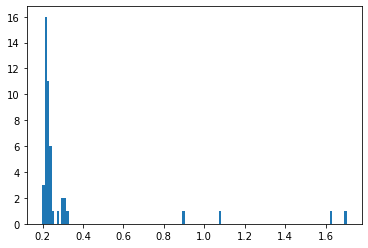

In [10]:
#compute_bins(hough_space,query_shape,train_shape):

values = {}

data_scale = [entry['scale_ratio'] for entry in hough_space.values()]
counts_scale, bins_scale, patches_size = plt.hist(data_scale, bins='auto')
img_scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
#plt.close();

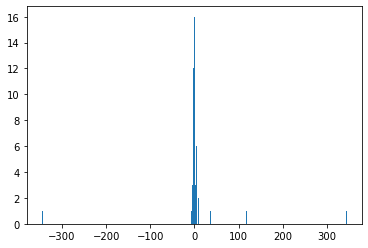

In [16]:
data_angle = [entry['delta_angle'] for entry in hough_space.values()]
counts_angle, bins_angle, patches_angle = plt.hist(data_angle, bins='auto')
#plt.close();

In [18]:
BIN_PRECISION_FACTOR = 0.25
ANGLE_BINS = 7
ANGLE_BIN_SIZE_COEFF = 0.1
SCALE_BIN_SIZE_COEFF = 0.1

query_shape = imgs_dict['0']['shape']
train_shape = imgs_dict['m1']['shape']

x_bin_size = img_scale * query_shape[1] * BIN_PRECISION_FACTOR
y_bin_size = img_scale * query_shape[0] * BIN_PRECISION_FACTOR
x_bins = int(np.ceil(train_shape[1] / x_bin_size) + 2)
y_bins = int(np.ceil(train_shape[0] / y_bin_size) + 2)
x_min = train_shape[1] / 2 - x_bins / 2 * x_bin_size
y_min = train_shape[0] / 2 - y_bins / 2 * y_bin_size

angle_bin_size = np.std(data_angle) * ANGLE_BIN_SIZE_COEFF
angle_bin_center = np.mean(data_angle)
angle_min = angle_bin_center - ANGLE_BINS / 2 * angle_bin_size
angle_max = angle_bin_center + ANGLE_BINS / 2 * angle_bin_size

scale_bin_size = np.std(data_scale) * SCALE_BIN_SIZE_COEFF
scale_bin_center = np.mean(data_scale)
scale_min = 0 
scale_max = scale_bin_center * 2 
scale_bins = int((scale_max - scale_min) / scale_bin_size)

bins_values = {}
bins_values['x_bins'] = x_bins
bins_values['y_bins'] = y_bins
bins_values['x_min'] = x_min
bins_values['y_min'] = y_min
bins_values['x_bin_size'] = x_bin_size
bins_values['y_bin_size'] = y_bin_size
bins_values['scale_bins'] = scale_bins
bins_values['scale_min'] = scale_min
bins_values['scale_bin_size'] = scale_bin_size
bins_values['angle_min'] = angle_min
bins_values['angle_bin_size'] = angle_bin_size  

    #return values

In [19]:
bins_values

{'x_bins': 26,
 'y_bins': 8,
 'x_min': -64.17642399103977,
 'y_min': -90.69481684275934,
 'x_bin_size': 59.70587876854152,
 'y_bin_size': 81.04870421068983,
 'scale_bins': 20,
 'scale_min': 0,
 'scale_bin_size': 0.03215630504264163,
 'angle_min': -21.34274293227928,
 'angle_bin_size': 7.3309366093378205}

In [21]:
accumulator = np.zeros((bins_values['x_bins'], bins_values['y_bins'], ANGLE_BINS, bins_values['scale_bins']))

votes = {}

for idx, v in hough_space.items():
    try:
        for x in range(0, 2):
            for y in range(0, 2):
                for z in range(0, 2):
                    for w in range(0, 2):                
                        i = int(np.floor((v['x_c'] - bins_values['x_min'] + (x - 1 / 2) * bins_values['x_bin_size']) / bins_values['x_bin_size']))
                        j = int(np.floor((v['y_c'] - bins_values['y_min'] + (y - 1 / 2) * bins_values['y_bin_size']) / bins_values['y_bin_size']))
                        k = int(np.floor((v['delta_angle'] - bins_values['angle_min'] + (z - 1 / 2) * bins_values['angle_bin_size']) / bins_values['angle_bin_size']))
                        l = int(np.floor((v['scale_ratio'] - bins_values['scale_min'] + (w - 1 / 2) * bins_values['scale_bin_size']) / bins_values['scale_bin_size']))
                        if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                            accumulator[i, j, k, l] += 1
                            votes[(i, j, k, l)] = votes.get((i, j, k, l), [])
                            votes[(i, j, k, l)].append(idx)
    except: pass

In [22]:
votes

{(15, 2, 2, 5): [1623],
 (15, 2, 2, 6): [1623, 1722, 2035],
 (15, 2, 3, 5): [1623],
 (15, 2, 3, 6): [1623, 1722, 1745, 1982, 2035],
 (15, 3, 2, 5): [1623],
 (15, 3, 2, 6): [1623, 1722, 1903, 1904, 2034, 2035],
 (15, 3, 3, 5): [1623],
 (15, 3, 3, 6): [1623, 1722, 1745, 1903, 1904, 1982, 2034, 2035],
 (16, 2, 2, 5): [1623],
 (16, 2, 2, 6): [1623, 1722, 2035, 2140, 2150, 2198, 2216, 2267, 2325],
 (16, 2, 3, 5): [1623],
 (16, 2, 3, 6): [1623,
  1722,
  1745,
  1982,
  2035,
  2121,
  2140,
  2150,
  2198,
  2216,
  2267,
  2325],
 (16, 3, 2, 5): [1623, 1793],
 (16, 3, 2, 6): [1623,
  1722,
  1903,
  1793,
  2034,
  2035,
  2064,
  2140,
  2150,
  2151,
  2193,
  2198,
  2195,
  2216,
  2232,
  2267,
  2325,
  2385],
 (16, 3, 3, 5): [1623, 1793],
 (16, 3, 3, 6): [1623,
  1722,
  1727,
  1745,
  1903,
  1793,
  1982,
  2034,
  2035,
  2064,
  2121,
  2140,
  2150,
  2151,
  2193,
  2198,
  2195,
  2216,
  2217,
  2232,
  2267,
  2325,
  2385],
 (13, 4, 1, 6): [1654],
 (13, 4, 1, 7): [1654],


In [23]:
import skimage.morphology as sk

ModuleNotFoundError: No module named 'skimage'